In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
#import shap

import sys
sys.path.append('/home/rl_sim/TACTILEDRIVEN_ARTO/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
import tensorflow as tf
gpus = tensorflow.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
# Set GPU 1 (the second GPU) to be the only visible device
if gpus:
    try:
        tf.config.set_visible_devices(gpus[1], 'GPU')
        
        # Optionally, set memory growth to avoid allocating all memory on the GPU at once
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        print(e)


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/rl_sim/TACTILEDRIVEN_ARTO/ML/DATA/1D_GRIPA_FTP_ScalNorm/'

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

import tensorflow as tf

# Function to generate Grad-CAM heatmap
def grad_cam(model, layer_name, data):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(layer_name).output, model.output]
    )
    last_conv_layer_output, preds = grad_model(data)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0))
    
    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    return heatmap

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}
def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = np.dstack((data[:, :, 0],))
        globals()[f"{key}2"] = np.dstack((data[:, :, 2],))
        globals()[f"{key}3"] = np.dstack((data[:, :, 6], data[:, :, 8]))
        # Uncomment and modify the line below if you need the fourth set
        # globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 8]))

# Example usage
assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
#print("X_train4 shape:", X_train4.shape)


import tensorflow as tf

WS_B = 800  # Example sequence length
input_shape1 = (WS_B, 1)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 2)

OUT_N = int(np.max(y_data))  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N+1))  # Generate labels from 0 to OUT_N+1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

def compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)")
    axs[0].plot(history.history["val_loss"], label="val_loss")
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy")
    axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return history, loss, accuracy, f1, y_pred_labels

2024-07-11 11:32:23.616000: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 11:32:23.642961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 11:32:24.076894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-11 11:32:24.414089: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
X_data shape: (1465, 800, 9)
y_data shape: (1465,)
X_data.[0] shape:  (800, 9)
y_data.[0] max:  1.0
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800, 9)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800, 9)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800, 9)    ||  Dimensions of y_val:   (293,)
Shapes of the stacked arrays:
X_train1 shape: (879, 800, 1)
X_train2 shape: (879, 800, 1)
X_train3 shape: (879, 800, 2)
OUT_N: 1
DISP_LABELS: [0, 1]


2024-07-11 11:32:24.730264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 11:32:24.730552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 11:32:24.730702: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 800, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 800, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 80, 64)    │      2,624 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 80, 64)    │      2,624 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 80, 64)    │      5,184 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 37, 128)   │     65,664 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 37, 128)   │     65,664 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 37, 128)   │     65,664 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 37, 128)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 37, 128)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 37, 128)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 36, 256)   │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 36, 256)   │     65,792 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 36, 256)   │     65,792 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_2         │ (None, 36, 256)   │          0 │ conv1d_1_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_2         │ (None, 36, 256)   │          0 │ conv1d_2_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_2         │ (None, 36, 256)   │          0 │ conv1d_3_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ dropout_1_2[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ dropout_2_2[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 256)       │          0 │ dropout_3_2[0][0

 Total params: 454,081 (1.73 MB)

 Trainable params: 454,081 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


I0000 00:00:1720690345.870724 2455048 service.cc:145] XLA service 0x7fe318004d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720690345.870751 2455048 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-07-11 11:32:25.927032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 11:32:26.104521: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/28 ━━━━━━━━━━━━━━━━━━━━ 2:23 5s/step - accuracy: 0.5625 - loss: 0.6880

I0000 00:00:1720690350.211603 2455048 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.5386 - loss: 0.6990 - val_accuracy: 0.5563 - val_loss: 0.6487
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6281 - loss: 0.6366 - val_accuracy: 0.6621 - val_loss: 0.6149
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6576 - loss: 0.5819 - val_accuracy: 0.6041 - val_loss: 0.6217
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6827 - loss: 0.5626 - val_accuracy: 0.5939 - val_loss: 0.6284
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6764 - loss: 0.5552 - val_accuracy: 0.6519 - val_loss: 0.5722
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7076 - loss: 0.5702 - val_accuracy: 0.7270 - val_loss: 0.5315
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7415 - loss: 0.4799 - val_accuracy: 0.7338 - val_loss: 0.4942
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7409 - loss: 0.4927 - val_accuracy: 0.7099 - val_loss: 0.5115


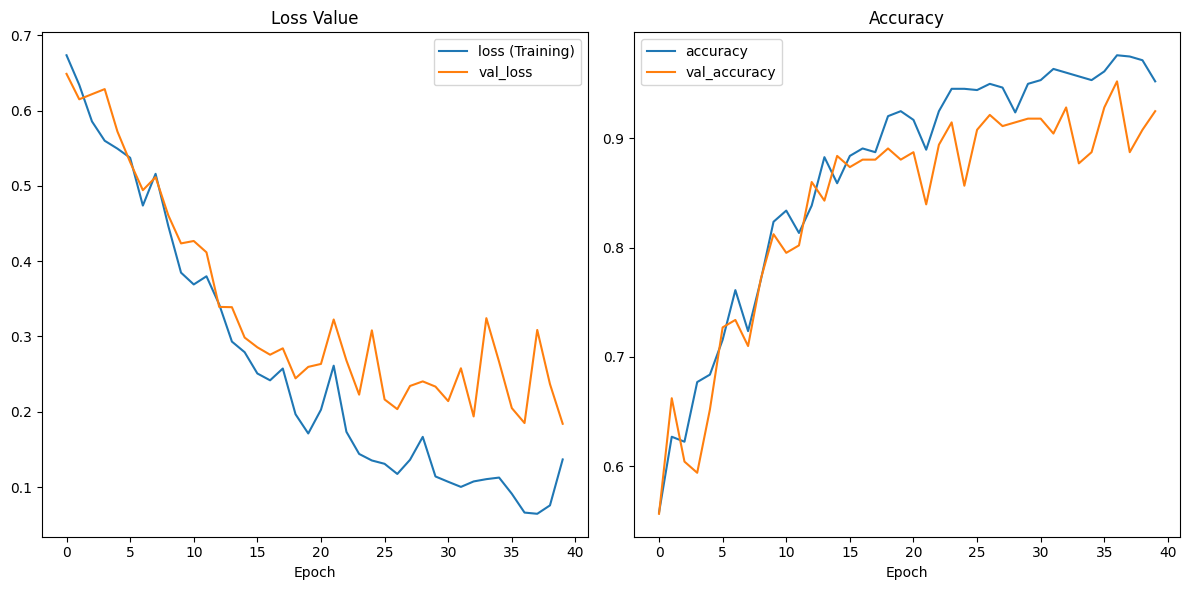

Test loss: 0.41968390345573425
Test accuracy: 0.8737201365187713
F1 Score: 0.8737201365187713
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       137
         1.0       0.93      0.82      0.87       156

    accuracy                           0.87       293
   macro avg       0.88      0.88      0.87       293
weighted avg       0.88      0.87      0.87       293



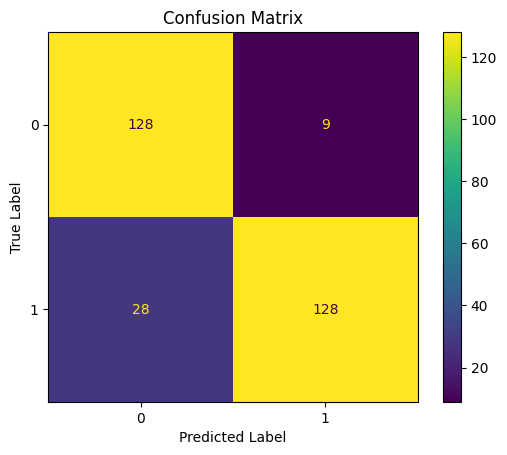

In [2]:
FILTN = 1
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        x = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.22, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = Dropout(rate=0.20, name=f'dropout_{branch_id}_2')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3]
model = build_branched_model(input_shapes)
model.summary()

X_train = [X_train1, X_train2, X_train3]
X_val   = [X_val1, X_val2, X_val3]
X_test  = [X_test1, X_test2, X_test3]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=40, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [3]:
# model_name = "MOD_AUGnostr_SPEED_3Cnv_2Dens2Drpt_40krn_97"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 800, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 800, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 80, 128)   │      5,248 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 80, 128)   │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 80, 128)   │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 39, 256)   │    131,328 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 39, 256)   │    131,328 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 39, 256)   │    131,328 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ conv1d_2_2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 256)       │          0 │ conv1d_3_2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,129 (1.77 MB)

 Trainable params: 464,129 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5336 - loss: 0.6886 - val_accuracy: 0.5324 - val_loss: 0.6647
Epoch 2/120
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6476 - loss: 0.6361 - val_accuracy: 0.6382 - val_loss: 0.6389
Epoch 3/120
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6622 - loss: 0.6283 - val_accuracy: 0.6177 - val_loss: 0.6375
Epoch 4/120
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6274 - loss: 0.5940 - val_accuracy: 0.6177 - val_loss: 0.6250
Epoch 5/120
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6489 - loss: 0.6035 - val_accuracy: 0.6416 - val_loss: 0.6213
Epoch 6/120
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6826 - loss: 0.5886 - val_accuracy: 0.5734 - val_loss: 0.6481
Epoch 7/120
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6604 - loss: 0.5769 - val_accuracy: 0.6621 - val_loss: 0.6178
Epoch 8/120
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.5869 - val_accuracy: 0.6177 - 

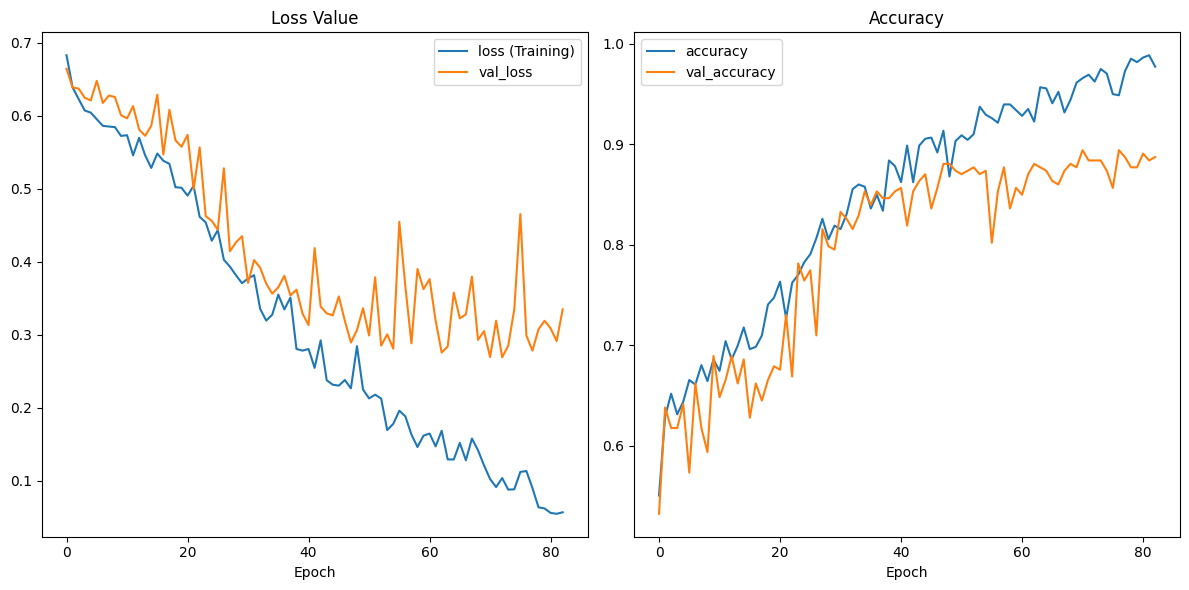

Test loss: 0.28896400332450867
Test accuracy: 0.8976109215017065
F1 Score: 0.8970822405395279
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       137
         1.0       0.90      0.91      0.90       156

    accuracy                           0.90       293
   macro avg       0.90      0.90      0.90       293
weighted avg       0.90      0.90      0.90       293



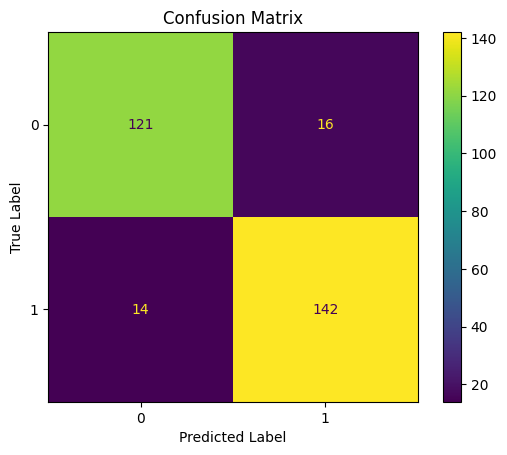

In [4]:
FILTN = 2
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        x = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        # x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        # x = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalAveragePooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3]
model = build_branched_model(input_shapes)
model.summary()


X_train = [X_train1, X_train2, X_train3]
X_val   = [X_val1, X_val2, X_val3]
X_test  = [X_test1, X_test2, X_test3]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=120, batch_size=32, patience=10, disp_labels=DISP_LABELS)

In [5]:
# model_name = "3MOD_SPEED_2Cnv_2Dens_100krn_95"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 800, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 800, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 80, 128)   │      5,248 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 80, 128)   │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 80, 128)   │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 79, 256)   │     65,792 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 79, 256)   │     65,792 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 79, 256)   │     65,792 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 79, 256)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 79, 256)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 79, 256)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 36, 512)   │  1,049,088 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 36, 512)   │  1,049,088 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 36, 512)   │  1,049,088 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 512)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 512)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1536)      │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    196,736 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dense_1[0][0]   

 Total params: 3,562,369 (13.59 MB)

 Trainable params: 3,562,369 (13.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.4848 - loss: 0.7287 - val_accuracy: 0.4744 - val_loss: 0.6866
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5449 - loss: 0.6712 - val_accuracy: 0.6519 - val_loss: 0.6343
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6583 - loss: 0.6135 - val_accuracy: 0.6348 - val_loss: 0.6379
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6242 - loss: 0.6242 - val_accuracy: 0.6348 - val_loss: 0.6200
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6458 - loss: 0.6097 - val_accuracy: 0.6485 - val_loss: 0.6197
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6308 - loss: 0.6143 - val_accuracy: 0.6246 - val_loss: 0.6289
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6281 - loss: 0.5995 - val_accuracy: 0.6553 - val_loss: 0.6069
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6568 - loss: 0.5845 - val_accuracy: 0.6348 - val_los

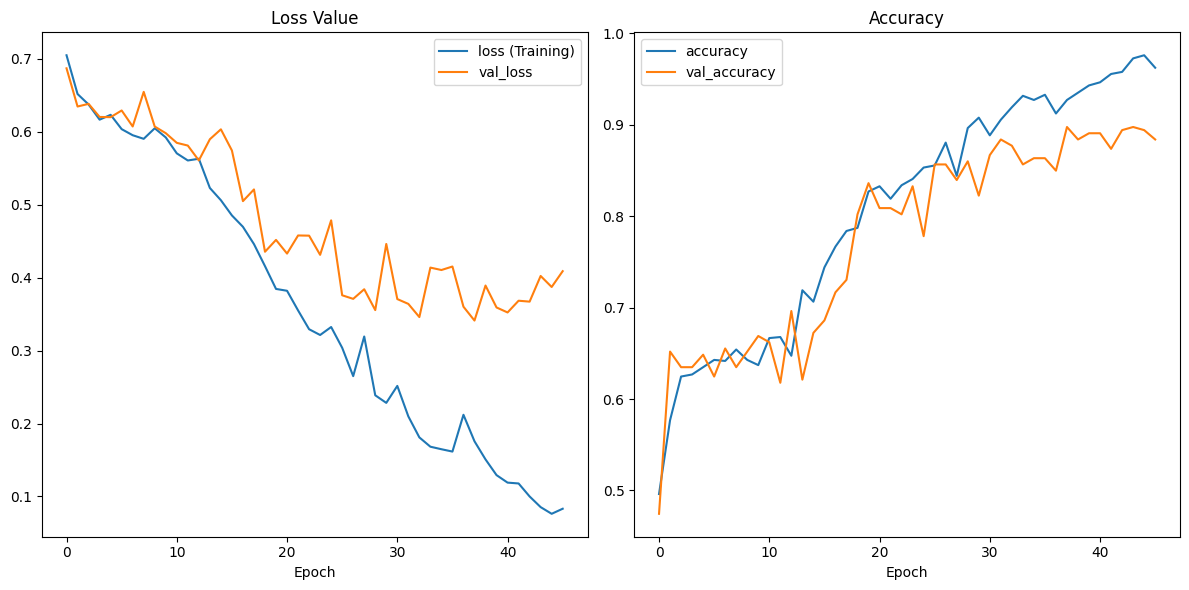

Test loss: 0.29436787962913513
Test accuracy: 0.8600682593856656
F1 Score: 0.8585857396791016
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       137
         1.0       0.84      0.90      0.87       156

    accuracy                           0.86       293
   macro avg       0.86      0.86      0.86       293
weighted avg       0.86      0.86      0.86       293



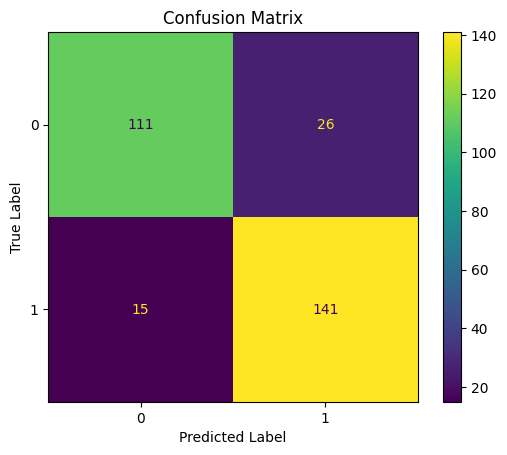

In [6]:
FILTN = 2
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        x = Conv1D(filters=128*FILTN, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=256*FILTN, kernel_size=8, strides=2, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalAveragePooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(128, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3]
model = build_branched_model(input_shapes)
model.summary()


X_train = [X_train1, X_train2, X_train3]
X_val   = [X_val1, X_val2, X_val3]
X_test  = [X_test1, X_test2, X_test3]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=60, batch_size=32, patience=8, disp_labels=DISP_LABELS)